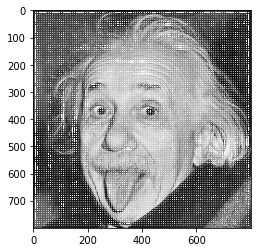

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_differential_filter():
    # To do
    #filter_x = np.tile(np.array([1,0,-1]),(3,1))
    #filter_y = np.tile(np.vstack(np.array([1,0,-1])),3)
    #gaussian = np.array([[0,1,0],[1,2,1],[0,1,0]]) # Add the gaussian filter to mimic Park?
    
    #using self-defined solbelman filter instead.
    filter_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    filter_x = filter_y.T
    
    #print(filter_x)
    #print(filter_y)
    
    return filter_x, filter_y


def filter_image(im, filter):
    # To do
    # padding image in oder to let pic surrounded by zeros rim
    im_zero_pad = np.pad(im, ((1,1),(1,1)), 'constant')
    height,width = im.shape
    im_filtered = np.zeros(im.shape)
    
    for i in range(height):
        for j in range(width):
            cell = im_zero_pad[i:i+3,j:j+3]
            im_filtered[i,j] = np.sum(cell*filter)    # filtering each cell patch with selected kernel
    
    # plotting the corresponded filtered pic (Optional)
    #plt.imshow(im_filtered ,cmap='jet')              
    #plt.show()
    
    return im_filtered


def get_gradient(im_dx, im_dy):
    # To do
    grad_mag = np.sqrt(im_dx**2+im_dy**2)
    
    grad_angle = np.zeros(im_dx.shape)
        
    for i in range(im_dx.shape[0]):
        for j in range(im_dy.shape[1]):
            grad_angle[i,j] = np.arctan2(im_dy[i,j],im_dx[i,j])
            
    # plotting the corresponded gradient angle pic (Optional)
    #plt.imshow(grad_angle % np.pi ,cmap='jet')
    #plt.show()
    
    # plotting the corresponded gradient magnitude pic (Optional)
    #plt.imshow(grad_mag ,cmap='jet')
    #plt.show()
    
    #grad_angle domain shrink from [-pi pi] to [0 pi]

    return grad_mag, grad_angle % np.pi 

def build_histogram(grad_mag, grad_angle, cell_size = 8):
    # To do
    # covert the angle from radian to degree 
    angle_im = np.degrees(grad_angle)
    
    #create the bin map based on the angle map
    oder_im = np.zeros(angle_im.shape)
    
    #case 1 angle_im>=15, angle_im<45
    oder_im[np.where(np.logical_and(angle_im>=15, angle_im<45))] = 1
    
    #case 2 angle_im>=45, angle_im<75
    oder_im[np.where(np.logical_and(angle_im>=45, angle_im<75))] = 2
    
    #case 3 angle_im>=75, angle_im<105
    oder_im[np.where(np.logical_and(angle_im>=75, angle_im<105))] = 3
    
    #case 4 angle_im>=105, angle_im<135
    oder_im[np.where(np.logical_and(angle_im>=105, angle_im<135))] = 4
    
    #case 5 angle_im>=135, angle_im<165
    oder_im[np.where(np.logical_and(angle_im>=135, angle_im<165))] = 5
    
    #case 0 angle_im>=165, angle_im<15
    oder_im[np.where(angle_im>=165)] = 0
    oder_im[np.where(angle_im<15)] = 0
    
    #create the ori_histo with M,N,bin shape
    ori_histo = np.zeros((oder_im.shape[0]//cell_size,oder_im.shape[1]//cell_size,6))
    
    for i in range(oder_im.shape[0]):
        for j in range(oder_im.shape[1]):
            
            # 3 dimensions of shape of ori_histo
            oder_x = i//cell_size  
            oder_y = j//cell_size
            bin_num = np.int(oder_im[i,j])
            
            #throw the each histogram into correspondent angle bins. 
            ori_histo[oder_x,oder_y, bin_num] =grad_mag[i,j] + ori_histo[oder_x,oder_y,bin_num]
    
    return ori_histo


def get_block_descriptor(ori_histo, block_size = 2):
    # To do
    eps = 0.001
    len_x = ori_histo.shape[0]-block_size+1
    len_y = ori_histo.shape[1]-block_size+1
    ori_histo_normalized = np.zeros((len_x,len_y,6,block_size,block_size))
    for i in range(len_x):
        for j in range(len_y):
            H_sum = np.sqrt(np.sum(ori_histo[i:i+block_size,j:j+block_size,:]**2)+eps**2) #find sum of hi
            
            ori_histo_normalized [i,j,:,:,:] = (ori_histo[i:i+block_size,j:j+block_size,:]/H_sum).reshape((6,2,2))
            
                  
                
    ori_histo_normalized = ori_histo_normalized.reshape((len_x,len_y,6*block_size**2)) #reshape the matrix

    return ori_histo_normalized


def extract_hog(im):
   # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    
    # normalized the pic
    im = im/np.max(im)
    
    # To do
    block_size = 2
    
    cell_size = 8
    
    dx,dy = get_differential_filter()
    
    im_dx = filter_image(im, dx)
    
    im_dy = filter_image(im, dy)
    
    grad_mag, grad_angle = get_gradient(im_dx, im_dy)
    
    ori_histo = build_histogram(grad_mag, grad_angle, cell_size)
    
    ori_histo_normalized =  get_block_descriptor(ori_histo, block_size)
    
    hog = ori_histo_normalized

    # visualize to verify
    visualize_hog(im, hog, cell_size, block_size)

    return hog


# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    
    #Optional, just for zooming in
    #plt.xlim(200,250)
    #plt.ylim(200,250)
    
    plt.show()
    


if __name__=='__main__':
    im = cv2.imread('e2.png', 0)
    hog = extract_hog(im)
